Perform a simple fit to the data, not taking 2D errorbars into account.

In [87]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import corner
import emcee

Define the functions needed for MCMC

In [89]:
def model(pars, x):
    return pars[0] * x + pars[1]

In [90]:
def lnprior(pars):
    if -10 < pars[0] < 10 and -10 < pars[1] < 10 and -10 < pars[2] < 10:
        return 0.
    else:
        return -np.inf

In [91]:
def lnprob(pars, x, y, yerr):
    return lnprior(pars) + lnlike(pars, x, y, yerr)

In [92]:
def lnlike(pars, x, y, yerr):
    invsig2 = 1./(yerr**2 + np.exp(2*pars[2]))
    model_y = model(pars, x)
    return -.5*np.sum((y-model_y)**2*invsig2 - np.log(invsig2))

Load and plot data, starting with flicker (f) vs stellar density (r)

params =  -0.525509606298 2.88909102256


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


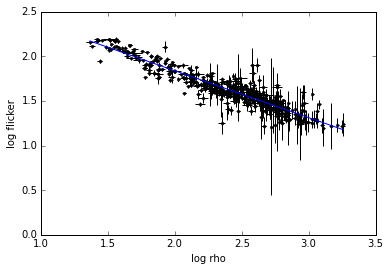

In [143]:
# load data
f, ferr, r, rerr = np.genfromtxt("../data/flickers.dat").T

# fit a line
AT = np.vstack((r, np.ones_like(r)))
ATA = np.dot(AT, AT.T)
m, c = np.linalg.solve(ATA, np.dot(AT, f))
print("params = ", m, c)

# plot data with best fit line
xs = np.linspace(min(r), max(r), 100)
ys = m * xs + c
plt.errorbar(r, f, xerr=rerr, yerr=ferr, fmt="k.", capsize=0)
plt.plot(xs, ys)
plt.ylabel("log flicker")
plt.xlabel("log rho")

Set up and run MCMC

In [144]:
pars_init = [m, c, np.log(3)]
print(lnlike(pars_init, r, f, ferr)) # check the lhf works

-482.639922813


In [94]:
ndim, nwalkers = 3, 24
pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]  # initialisation
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(r, f, ferr))
sampler.run_mcmc(pos, 10000)  # run MCMC
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))  # cut off burn in and flatten chains
samples[:, 2] = np.exp(samples[:, 2])
print(np.median(samples[:, 0]), np.median(samples[:, 1]), np.median(samples[:, 2]))  # print results

-0.525794412598 2.89229875575 0.0658412211417


Plot marginals

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


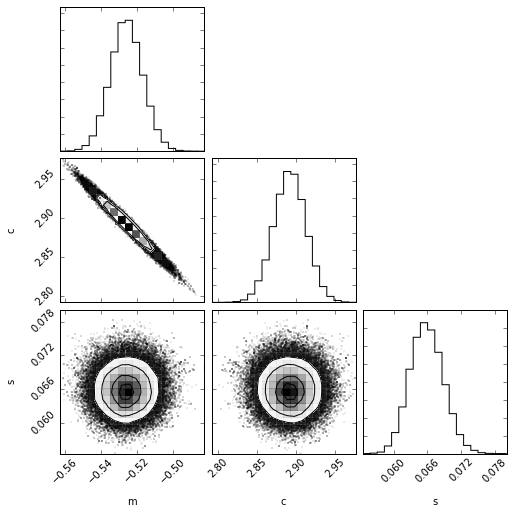

In [95]:
fig = corner.corner(samples, labels=["m", "c", "s"])

Now repeat the process above for flicker vs log g

-0.907669661991 5.2013608387


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


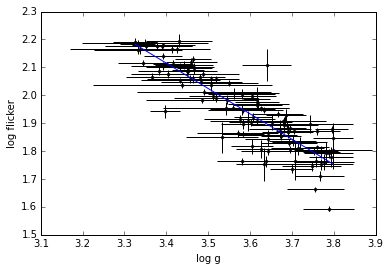

In [145]:
# load data
f, ferr, l, lerr, _, _ = np.genfromtxt("../data/log.dat").T
m = l < 3.8
f, ferr, l, lerr = f[m], ferr[m], l[m], lerr[m]

# fit a line
C = np.diag(ferr)
AT = np.vstack((l, np.ones_like(l)))
ATA = np.dot(AT, AT.T)
m, c = np.linalg.solve(ATA, np.dot(AT, f))
print(m, c)

# plot data
xs = np.linspace(min(l), max(l), 100)
ys = m * xs + c
plt.errorbar(l, f, xerr=lerr, yerr=ferr, fmt="k.", capsize=0)
plt.plot(xs, ys)
plt.ylabel("log flicker")
plt.xlabel("log g")

In [146]:
pars_init = [m, c, np.log(3)]
pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(l, f, ferr))
sampler.run_mcmc(pos, 10000)
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))
samples[:, 2] = np.exp(samples[:, 2])
new_m, new_c, s = np.median(samples[:, 0]), np.median(samples[:, 1]), np.median(samples[:, 2])
print("params = ", m, c, s)

params =  -0.907669661991 5.2013608387 0.05867953168


Plot marginals

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


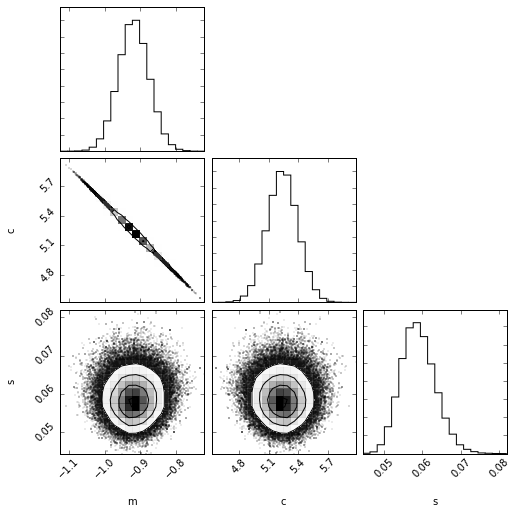

In [147]:
fig = corner.corner(samples, labels=["m", "c", "s"])

Calculate the interpretation of the "s" parameter

In [149]:
print("add", s, "onto every errorbar, on average")
print("errorbars underestimated by a factor of", s/np.mean(ferr), "on average")

add 0.05867953168 onto every errorbar, on average
errorbars underestimated by a factor of 3.2002894667 on average


Now add s, the extra scatter (square root of the extra variance) to the errorbars and check that no extra scatter is needed to explain the data. s should be consistent with zero.

In [139]:
pars_init = [new_m, new_c, np.log(s)]
pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(l, f, ferr+s))
sampler.run_mcmc(pos, 1000)
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
samples[:, 2] = np.exp(samples[:, 2])
print(np.median(samples[:, 0]), np.median(samples[:, 1]), np.median(samples[:, 2]))

-0.922074968482 5.25507794459 0.00152667398702


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


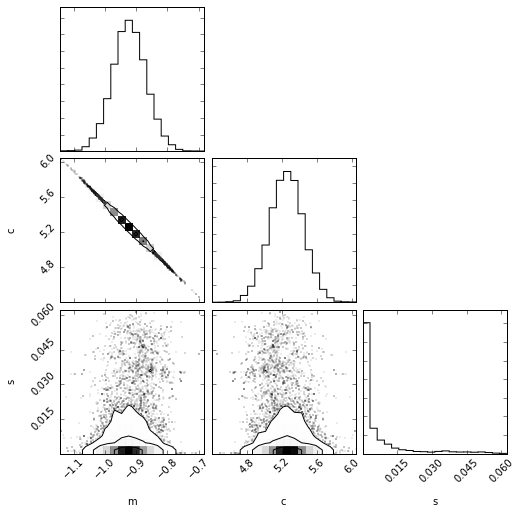

In [140]:
fig = corner.corner(samples, labels=["m", "c", "s"])

This looks correct!